# Классификация и сегментация клиентов iFood





### Постановка задачи



### Компания iFood собирает данные о клиентах и их покупках. Цель — понять поведение клиентов, выделить сегменты (кластеризация) и научиться предсказывать, откликнется ли клиент на маркетинговую кампанию (классификация, целевая переменная - Response).



### Подключение модулей

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=[FutureWarning, UserWarning])
sns.set_style("whitegrid")

In [36]:
df = pd.read_csv("ifood_df.csv")

In [37]:
df.head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,marital_Together,marital_Widow,education_2n Cycle,education_Basic,education_Graduation,education_Master,education_PhD,MntTotal,MntRegularProds,AcceptedCmpOverall
0,58138.0,0,0,58,635,88,546,172,88,88,...,0,0,0,0,1,0,0,1529,1441,0
1,46344.0,1,1,38,11,1,6,2,1,6,...,0,0,0,0,1,0,0,21,15,0
2,71613.0,0,0,26,426,49,127,111,21,42,...,1,0,0,0,1,0,0,734,692,0
3,26646.0,1,0,26,11,4,20,10,3,5,...,1,0,0,0,1,0,0,48,43,0
4,58293.0,1,0,94,173,43,118,46,27,15,...,0,0,0,0,0,0,1,407,392,0


# Описание данных
# Числовые признаки:

### Income — годовой доход
### Kidhome, Teenhome — количество детей и подростков
### Recency — дней с последней покупки
### MntWines, MntFruits, MntMeatProducts, ... — суммы трат по категориям
### NumDealsPurchases, NumWebPurchases, ... — количество покупок разными каналами
### NumWebVisitsMonth — посещений сайта за месяц
### AcceptedCmp1–5, AcceptedCmpOverall — принятие предыдущих кампаний
### Age — возраст
### Customer_Days — сколько дней клиент
### MntTotal, MntRegularProds — итоговые траты

# Целевая переменная:

### Response — отклик на последнюю кампанию (0 / 1)

In [38]:
df.shape

(2205, 39)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Income                2205 non-null   float64
 1   Kidhome               2205 non-null   int64  
 2   Teenhome              2205 non-null   int64  
 3   Recency               2205 non-null   int64  
 4   MntWines              2205 non-null   int64  
 5   MntFruits             2205 non-null   int64  
 6   MntMeatProducts       2205 non-null   int64  
 7   MntFishProducts       2205 non-null   int64  
 8   MntSweetProducts      2205 non-null   int64  
 9   MntGoldProds          2205 non-null   int64  
 10  NumDealsPurchases     2205 non-null   int64  
 11  NumWebPurchases       2205 non-null   int64  
 12  NumCatalogPurchases   2205 non-null   int64  
 13  NumStorePurchases     2205 non-null   int64  
 14  NumWebVisitsMonth     2205 non-null   int64  
 15  AcceptedCmp3         

In [40]:
df.describe().round(2)

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,marital_Together,marital_Widow,education_2n Cycle,education_Basic,education_Graduation,education_Master,education_PhD,MntTotal,MntRegularProds,AcceptedCmpOverall
count,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,2205.00,...,2205.00,2205.00,2205.00,2205.00,2205.0,2205.00,2205.00,2205.00,2205.00,2205.00
mean,51622.09,0.44,0.51,49.01,306.16,26.40,165.31,37.76,27.13,44.06,...,0.26,0.03,0.09,0.02,0.5,0.17,0.22,562.76,518.71,0.30
std,20713.06,0.54,0.54,28.93,337.49,39.78,217.78,54.82,41.13,51.74,...,0.44,0.18,0.29,0.15,0.5,0.37,0.41,575.94,553.85,0.68
min,1730.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,4.00,-283.00,0.00
25%,35196.00,0.00,0.00,24.00,24.00,2.00,16.00,3.00,1.00,9.00,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,56.00,42.00,0.00
50%,51287.00,0.00,0.00,49.00,178.00,8.00,68.00,12.00,8.00,25.00,...,0.00,0.00,0.00,0.00,1.0,0.00,0.00,343.00,288.00,0.00
75%,68281.00,1.00,1.00,74.00,507.00,33.00,232.00,50.00,34.00,56.00,...,1.00,0.00,0.00,0.00,1.0,0.00,0.00,964.00,884.00,0.00
max,113734.00,2.00,2.00,99.00,1493.00,199.00,1725.00,259.00,262.00,321.00,...,1.00,1.00,1.00,1.00,1.0,1.00,1.00,2491.00,2458.00,4.00


Распределение целевой переменной

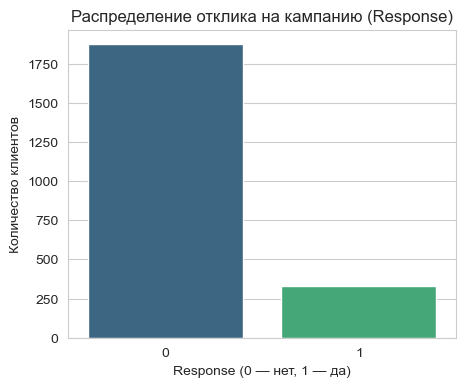

In [41]:
plt.figure(figsize=(5, 4))
sns.countplot(x='Response',data=df,palette='viridis',hue='Response',legend=False)
plt.title('Распределение отклика на кампанию (Response)')
plt.xlabel('Response (0 — нет, 1 — да)')
plt.ylabel('Количество клиентов')
plt.show()

Класс сильно несбалансирован — около 85% клиентов не откликнулись

# Разведочный анализ и визуализация

### Корреляционная тепловая карта

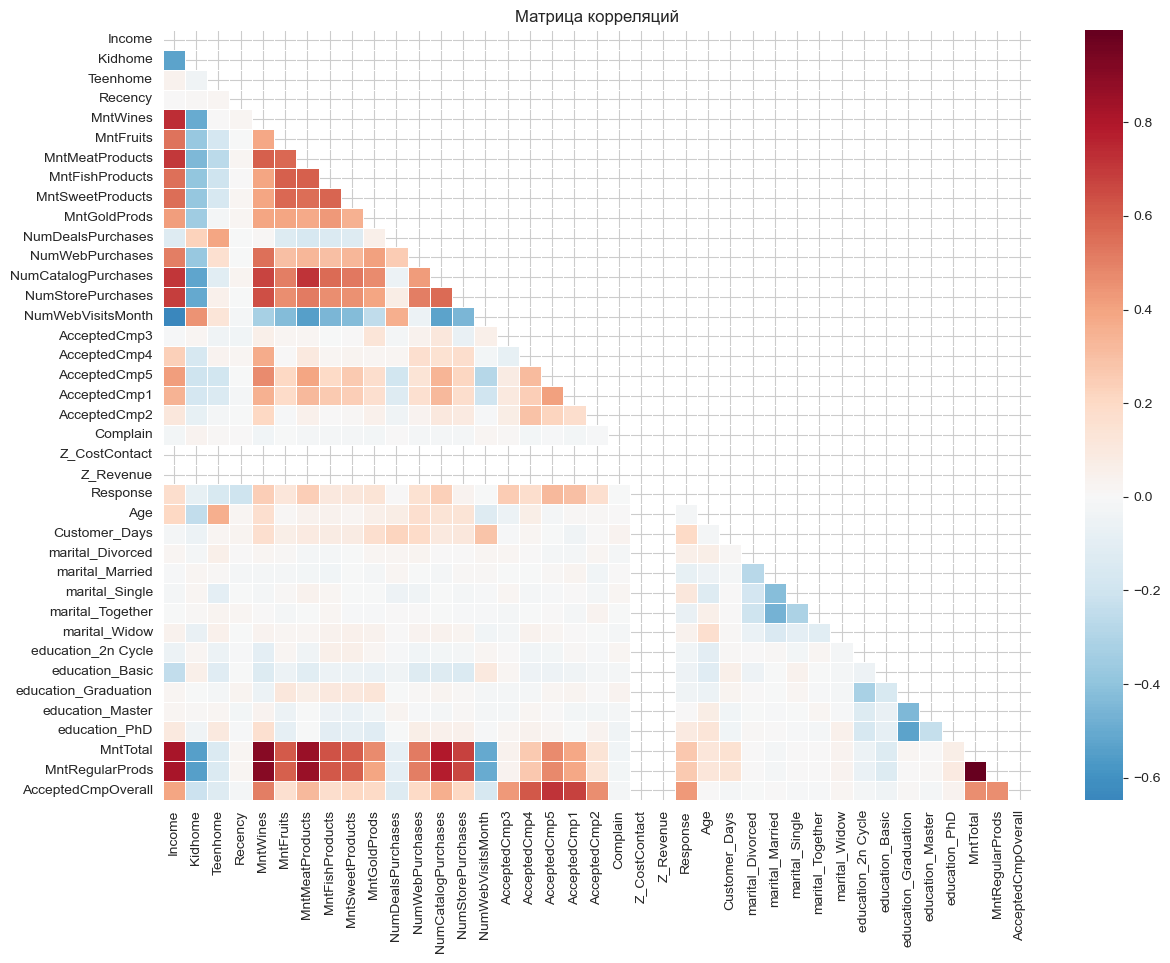

In [42]:
plt.figure(figsize=(14,10))
corr = df.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='RdBu_r', linewidths=0.4, center=0)
plt.title('Матрица корреляций')
plt.show()

Самые сильные связи - между доходом и общими тратами, а также между тратами на вино и общими тратами

### Распределения ключевых признаков

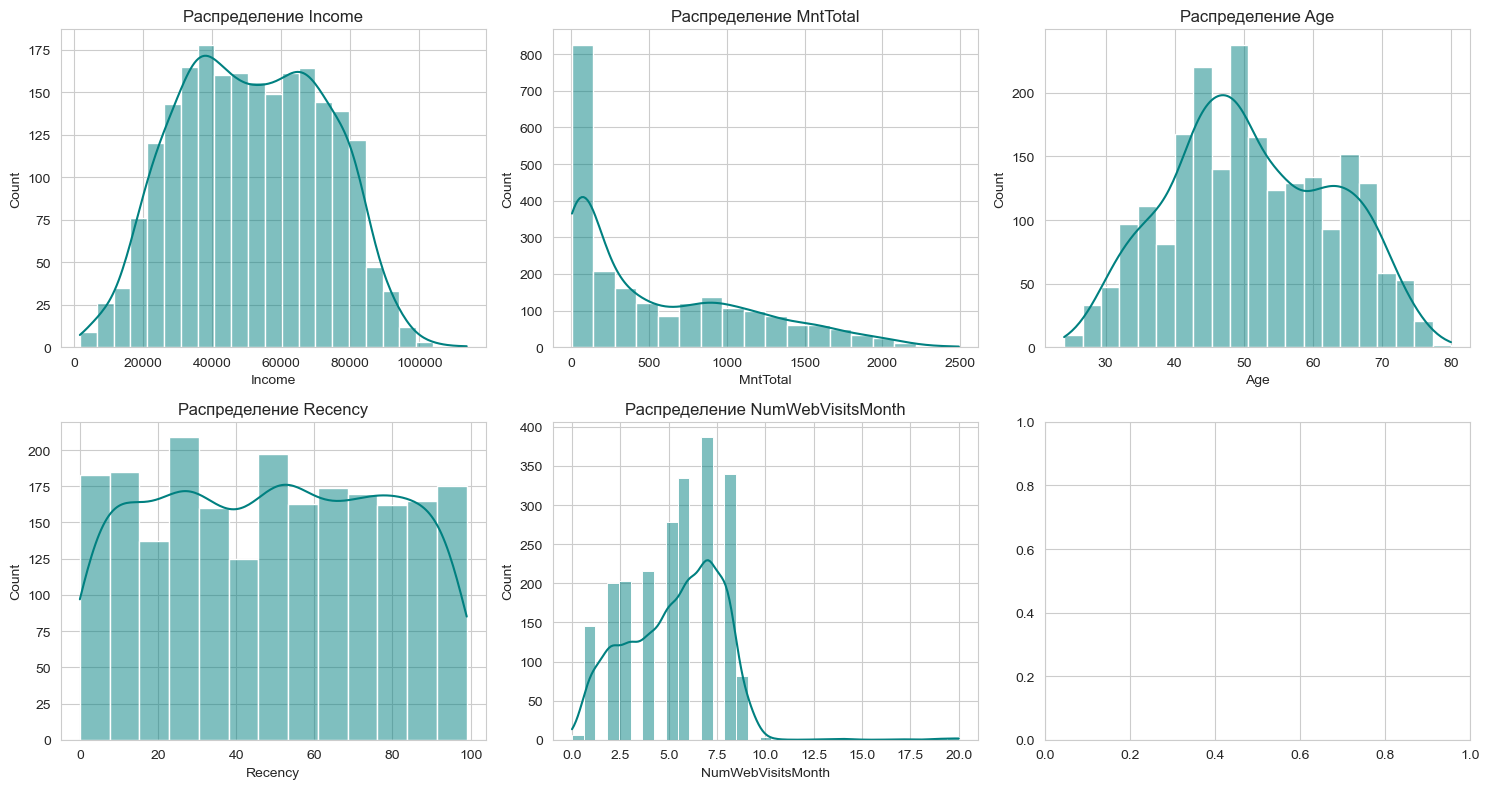

In [43]:
key_cols = ['Income', 'MntTotal', 'Age', 'Recency', 'NumWebVisitsMonth']

fig, axes = plt.subplots(2, 3, figsize=(15,8))
axes = axes.ravel()

for i, col in enumerate(key_cols):
    sns.histplot(df[col], kde=True, ax=axes[i], color='teal')
    axes[i].set_title(f'Распределение {col}')

plt.tight_layout()
plt.show()

### Распределения ключевых признаков

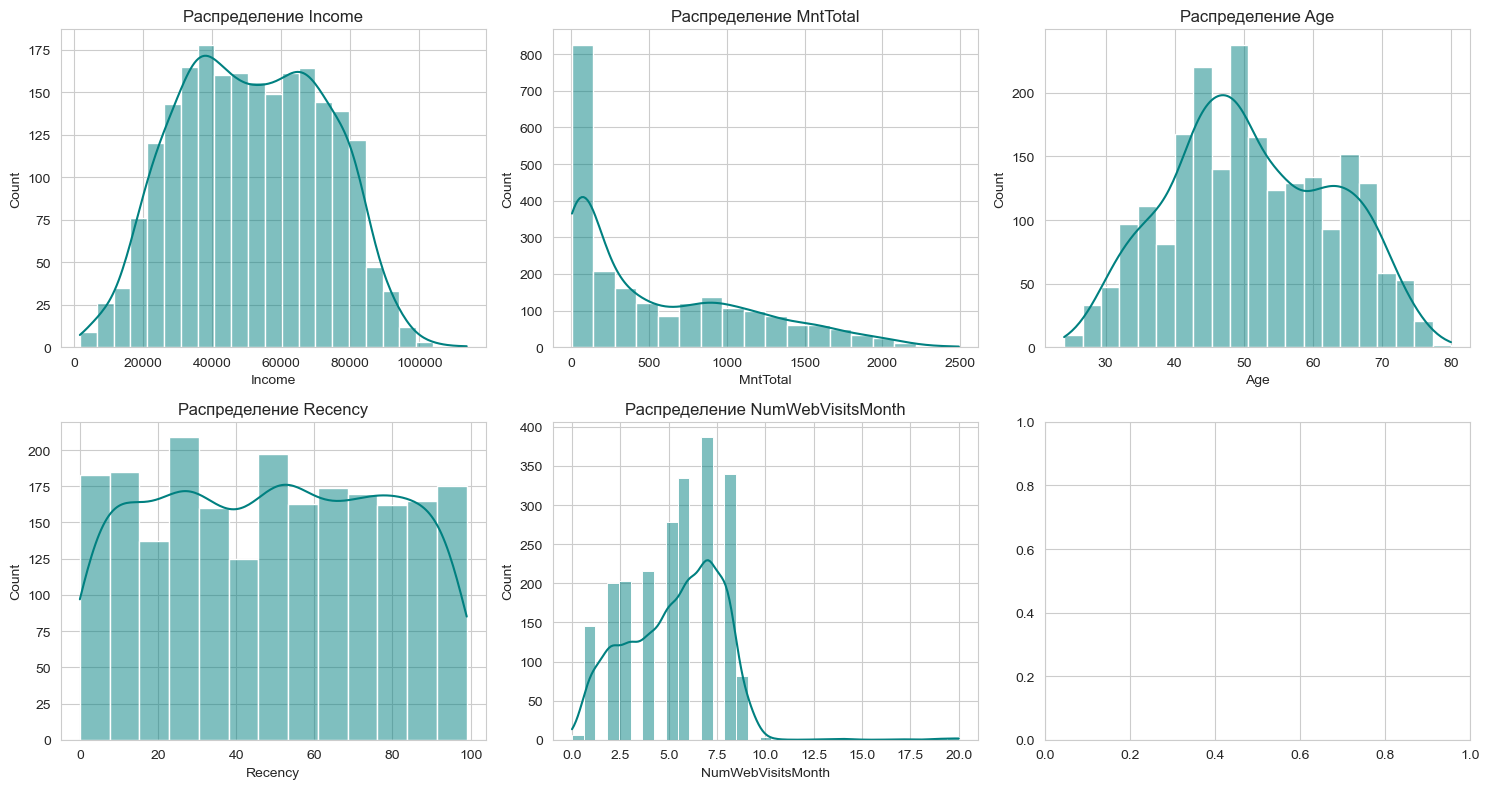

In [44]:
key_cols = ['Income', 'MntTotal', 'Age', 'Recency', 'NumWebVisitsMonth']

fig, axes = plt.subplots(2, 3, figsize=(15,8))
axes = axes.ravel()

for i, col in enumerate(key_cols):
    sns.histplot(df[col], kde=True, ax=axes[i], color='teal')
    axes[i].set_title(f'Распределение {col}')

plt.tight_layout()
plt.show()

Доход и общие траты имеют сильный правый хвост — большинство клиентов со средним и ниже среднего уровнем

### Затраты по категориям в зависимости от отклика

In [45]:
import warnings
import matplotlib as mpl
warnings.filterwarnings("ignore", message=".*vert.*deprecated.*")
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
warnings.filterwarnings("ignore", category=DeprecationWarning, module="matplotlib")

In [46]:
spend_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']

df_melt = df.melt(id_vars='Response', value_vars=spend_cols, var_name='Категория', value_name='Сумма')

print("df_melt создана, первые строки:")
print(df_melt.head(6))

df_melt создана, первые строки:
   Response Категория  Сумма
0         1  MntWines    635
1         0  MntWines     11
2         0  MntWines    426
3         0  MntWines     11
4         0  MntWines    173
5         0  MntWines    520


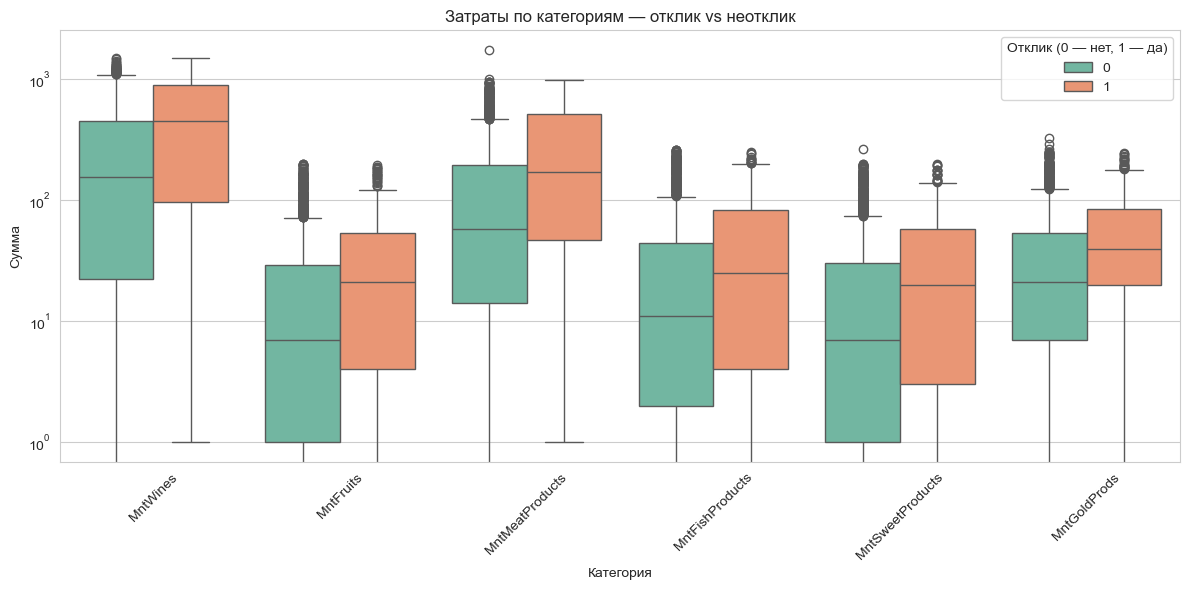

In [47]:
plt.figure(figsize=(12, 6))

sns.boxplot(x='Категория', y='Сумма', hue='Response', data=df_melt, palette='Set2')

plt.yscale('log')
plt.xticks(rotation=45)
plt.title('Затраты по категориям — отклик vs неотклик')
plt.legend(title='Отклик (0 — нет, 1 — да)')
plt.tight_layout()
plt.show()

Клиенты, откликнувшиеся на кампанию, значительно больше тратят на вино и мясные продукты

## Подготовка данных для кластеризации

Выбраны числовые признаки, которые лучше всего описывают поведение клиентов.

In [48]:
cluster_features = [
    'Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits',
    'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
    'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
    'NumStorePurchases', 'NumWebVisitsMonth', 'Age', 'MntTotal',
    'AcceptedCmpOverall'
]

X_cluster = df[cluster_features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

## Кластеризация (3 метода)

# KMeans (3 кластера)

Silhouette: 0.2403 | Davies-Bouldin: 1.7346


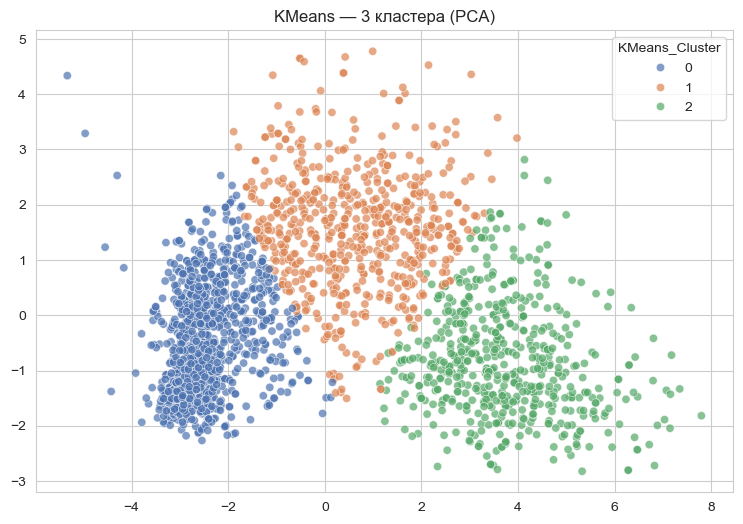

In [49]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

sil_k = silhouette_score(X_scaled, df['KMeans_Cluster'])
db_k  = davies_bouldin_score(X_scaled, df['KMeans_Cluster'])

print(f"Silhouette: {sil_k:.4f} | Davies-Bouldin: {db_k:.4f}")

plt.figure(figsize=(9,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['KMeans_Cluster'], palette='deep', alpha=0.7)
plt.title('KMeans — 3 кластера (PCA)')
plt.show()

# Вывод
### Три группы хорошо разделены. Один кластер сильно выделяется — вероятно состоятельные клиенты.

# DBSCAN

Найдено кластеров: 7 + шум


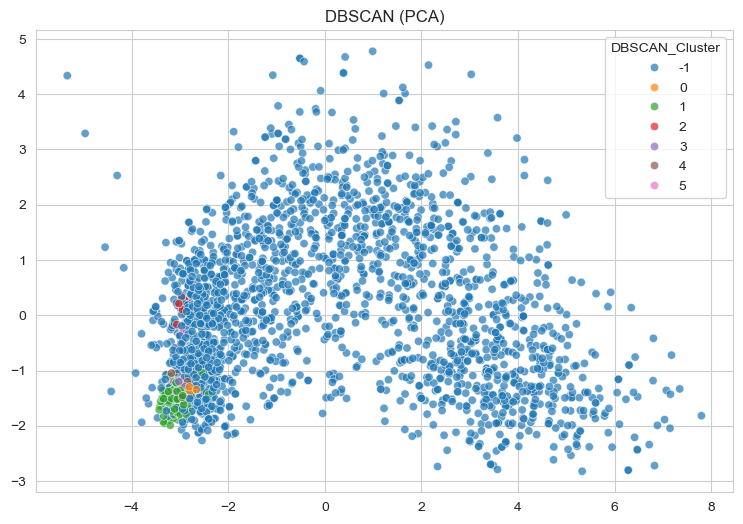

In [50]:
db = DBSCAN(eps=0.7, min_samples=6)
df['DBSCAN_Cluster'] = db.fit_predict(X_scaled)

n_clusters_db = len(set(df['DBSCAN_Cluster'])) - (1 if -1 in df['DBSCAN_Cluster'] else 0)
print(f"Найдено кластеров: {n_clusters_db} + шум")

plt.figure(figsize=(9,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['DBSCAN_Cluster'], palette='tab10', alpha=0.7)
plt.title('DBSCAN (PCA)')
plt.show()

# Вывод
### Много шума, мало кластеров. DBSCAN здесь работает хуже из-за разреженности данных.

# Agglomerative Clustering

Silhouette Agglomerative: 0.2314


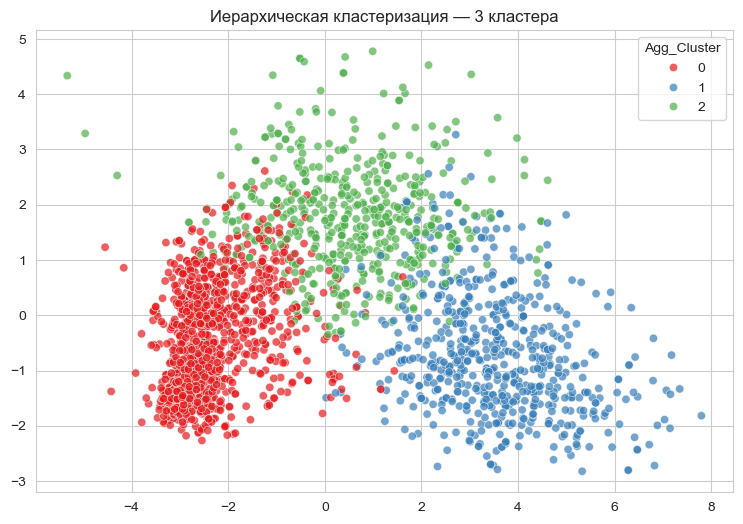

In [51]:
agg = AgglomerativeClustering(n_clusters=3)
df['Agg_Cluster'] = agg.fit_predict(X_scaled)

sil_agg = silhouette_score(X_scaled, df['Agg_Cluster'])
print(f"Silhouette Agglomerative: {sil_agg:.4f}")

plt.figure(figsize=(9,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['Agg_Cluster'], palette='Set1', alpha=0.7)
plt.title('Иерархическая кластеризация — 3 кластера')
plt.show()

# Вывод
### Результат похож на KMeans, границы чуть плавнее.

## Описание кластеров (KMeans)

In [52]:
cluster_desc = df.groupby('KMeans_Cluster')[cluster_features + ['Response', 'Income']].mean().round(1)
cluster_desc['Количество клиентов'] = df['KMeans_Cluster'].value_counts().sort_index()
cluster_desc

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,MntTotal,AcceptedCmpOverall,Response,Income,Количество клиентов
KMeans_Cluster,,,,,,,,,,,,,,,,,,,,,
0,34241.5,0.8,0.4,49.3,42.5,5.0,23.6,7.2,5.0,15.6,...,2.1,0.6,3.2,6.5,48.2,83.4,0.1,0.1,34241.5,1025
1,58132.2,0.2,0.9,47.8,451.8,22.9,134.2,30.6,23.6,60.3,...,6.3,3.1,7.8,5.6,55.6,663.1,0.3,0.1,58132.2,614
2,76035.3,0.0,0.2,49.8,625.6,69.0,455.7,100.8,71.0,77.9,...,5.2,6.0,8.4,2.9,51.4,1322.1,0.7,0.3,76035.3,566


# Вывод
### Кластер 0 — высокий доход и траты, высокий отклик.
### Кластер 1 — низкие траты, много визитов сайта, отклик почти нулевой.
### Кластер 2 — средний уровень, есть дети/подростки.

# Визуализация кластеров

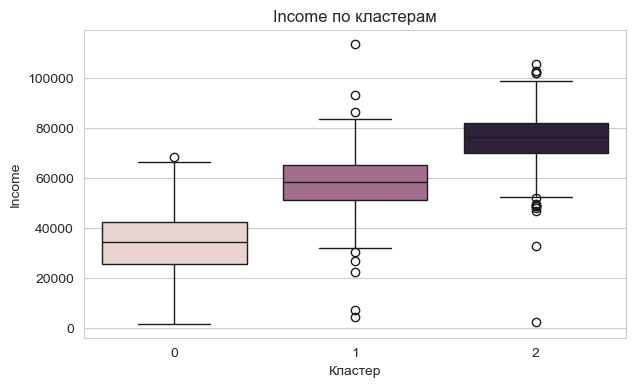

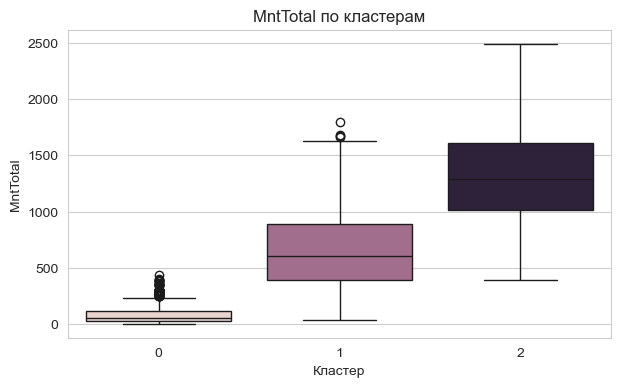

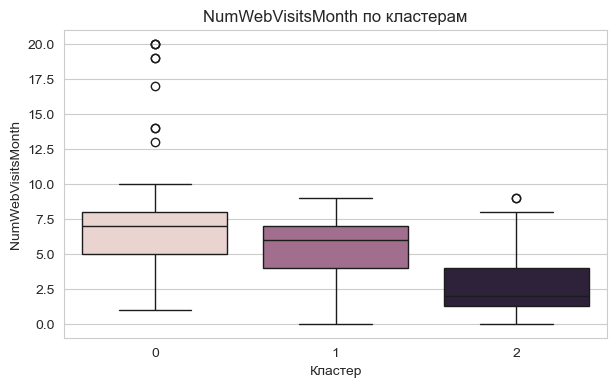

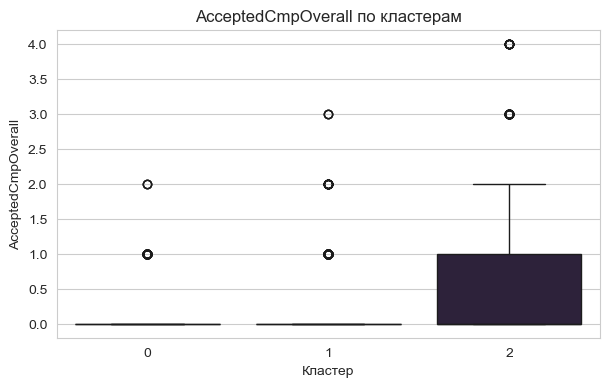

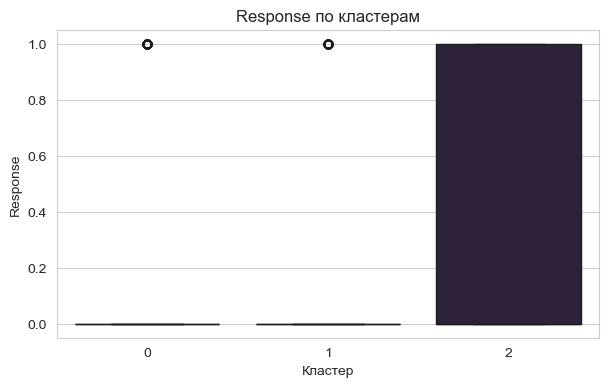

In [53]:
for col in ['Income', 'MntTotal', 'NumWebVisitsMonth', 'AcceptedCmpOverall', 'Response']:
    plt.figure(figsize=(7,4))
    sns.boxplot(x='KMeans_Cluster',
        y=col,
        data=df,
        hue='KMeans_Cluster', 
        legend=False
    )
    plt.title(f'{col} по кластерам')
    plt.xlabel('Кластер')
    plt.show()

## Вывод
### Кластер 0 значительно выделяется по доходу и тратам.
### Кластер 1 — самые низкие траты при высокой онлайн-активности

# Подготовка данных для классификации

In [54]:
X = df.drop(['Response', 'KMeans_Cluster', 'DBSCAN_Cluster', 'Agg_Cluster'], axis=1, errors='ignore')
y = df['Response']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Logistic Regression

Logistic Regression
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       469
           1       0.48      0.77      0.59        83

    accuracy                           0.84       552
   macro avg       0.72      0.81      0.74       552
weighted avg       0.88      0.84      0.85       552



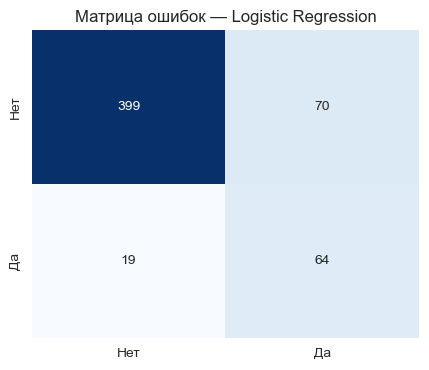

In [55]:
lr = LogisticRegression(class_weight='balanced', random_state=42)
lr.fit(X_train_scaled, y_train)
pred_lr = lr.predict(X_test_scaled)

print("Logistic Regression")
print(classification_report(y_test, pred_lr))

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, pred_lr),annot=True, fmt='d', cmap='Blues', cbar=False,xticklabels=['Нет', 'Да'], yticklabels=['Нет', 'Да'])
plt.title('Матрица ошибок — Logistic Regression')
plt.show()

## Random Forest

Random Forest
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       469
           1       0.70      0.25      0.37        83

    accuracy                           0.87       552
   macro avg       0.79      0.62      0.65       552
weighted avg       0.85      0.87      0.84       552



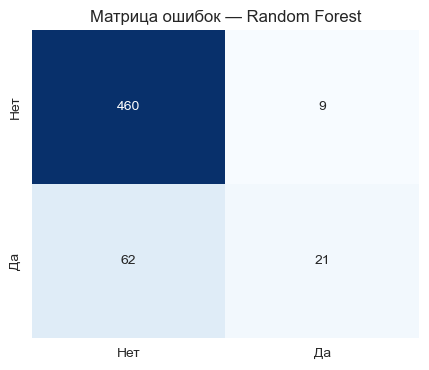

In [56]:
rf = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=200)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

print("Random Forest")
print(classification_report(y_test, pred_rf))

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, pred_rf), annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Нет', 'Да'], yticklabels=['Нет', 'Да'])
plt.title('Матрица ошибок — Random Forest')
plt.show()

## SVC

SVC
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       469
           1       0.51      0.70      0.59        83

    accuracy                           0.85       552
   macro avg       0.73      0.79      0.75       552
weighted avg       0.88      0.85      0.86       552



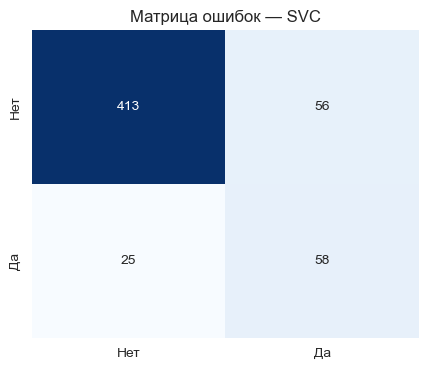

In [57]:
svc = SVC(class_weight='balanced', random_state=42)
svc.fit(X_train_scaled, y_train)
pred_svc = svc.predict(X_test_scaled)

print("SVC")
print(classification_report(y_test, pred_svc))

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, pred_svc),annot=True, fmt='d', cmap='Blues', cbar=False,xticklabels=['Нет', 'Да'], yticklabels=['Нет', 'Да'])
plt.title('Матрица ошибок — SVC')
plt.show()

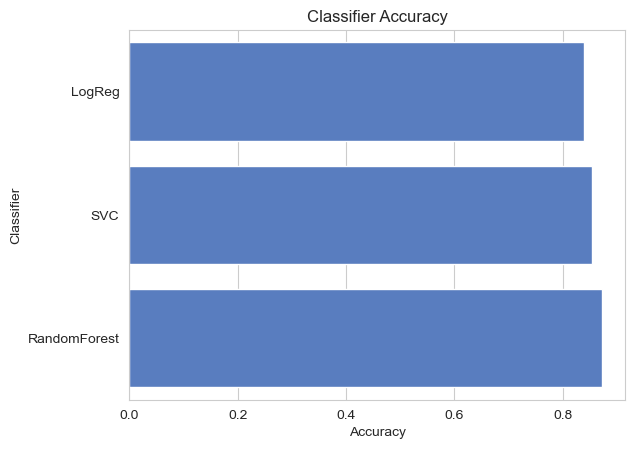

In [58]:
models_data = pd.DataFrame({'Classifier': ['LogReg','RandomForest','SVC'], 'Accuracy': [accuracy_score(y_test,pred_lr), accuracy_score(y_test,pred_rf), accuracy_score(y_test,pred_svc)]})
plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=models_data.sort_values(by='Accuracy'), color="b")
plt.show()

## Вывод
### Random Forest показывает лучшие результаты по F1-score

# Сохранение модели

In [59]:
import joblib
joblib.dump(rf, 'ifood_classification_model.pkl')
print("Модель Random Forest сохранена")

Модель Random Forest сохранена
